In [1]:
import keras 
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

Using TensorFlow backend.


57344/57026 [==============================] - 6s 109us/step


In [3]:
train_data.shape, test_data.shape

((404, 13), (102, 13))

Data processing

In [5]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

#### Netwwork building 

In [28]:
from keras import models
from keras import layers
from keras import regularizers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64,kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64,kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [29]:
k = 5
import numpy as np
num_val_samples = len(train_data) // k
num_epochs = 500
all_scores = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


In [30]:
# Train the model (in silent mode, verbose=0)
all_mae_histories = []
history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    
mae_history = history.history['val_mean_absolute_error']
all_mae_histories.append(mae_history)

In [31]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

Computing the average per-epoch MAE scores for all folds:

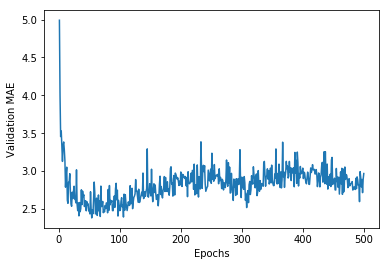

In [32]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

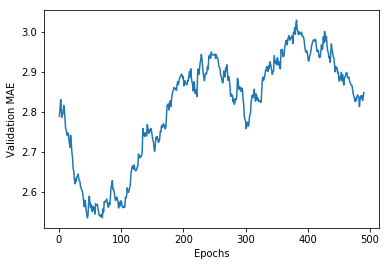

In [33]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()